# **Rodando Modelos: KMeans**
## **Pré-Processamento Pós EDA**
* Conversando com a Fernanda percebemos que nossa análise é sobre a partida então features de estatísticas gerais dos times não ou pouco importariam para o nosso clustering.
* Outra questão que percebemos também é que existem features do Time B que podem dizer comportamentos do time A (um time B com muitos erros pode indicar também um time A com alta Hit Pct). Então decidimos voltar atrás na retirada das colunas do time B
* Como times variam bastante de jogadores de um ano para o outro, decidimos diferenciar um time A de 2019 de um time A de 2018.
* para identificar isso iremos criar alguns ids como ID da Partida e ID do time naquele ano

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from scipy import stats


In [3]:
df = pd.read_csv("C:/Users/gabri/OneDrive/Documents/Faculdade/2024.2/Projeto de Ciência de Dados/novo/volleyball-case-study/data/para-o-projeto/team_v_team.csv")
df.head()

,Unnamed: 0,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,...,Team B Hit Pct,Team B Assists,Team B Aces,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS
0,0,8302019,USC Upstate,Virginia Tech,0,4.0,33,21,112,0.107,...,0.234,48,13,12,51,4,4,20,2,0.0
1,1,8302019,USC Upstate,Northwestern,0,3.0,16,24,89,-0.090,...,0.349,41,6,7,42,1,2,20,0,0.0
2,2,9072019,USC Upstate,Ga. Southern,0,3.0,37,20,117,0.145,...,0.239,39,4,5,49,2,1,6,1,50.0
3,3,9132019,USC Upstate,Norfolk St.,1,5.0,50,27,164,0.140,...,0.114,47,11,15,67,9,1,17,1,70.5
4,4,9142019,USC Upstate,George Washington,0,3.0,30,17,112,0.116,...,0.216,44,3,1,60,2,1,6,6,52.0


In [4]:
columns_team_A = ['Team A Kills', 'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
                  'Team A Assists', 'Team A Aces', 'Team A SErr', 'Team A Digs', 'Team A RErr',
                  'Team A Block Solos', 'Team A Block Assists', 'Team A BErr', 'Team A PTS']

columns_team_B = ['Team B Kills', 'Team B Errors', 'Team B Total Attacks', 'Team B Hit Pct',
                  'Team B Assists', 'Team B Aces', 'Team B SErr', 'Team B Digs', 'Team B RErr',
                  'Team B Block Solos', 'Team B Block Assists', 'Team B BErr', 'Team B PTS']

In [5]:
df['duplicata_id'] = df.apply(lambda row: f"{row['Date']}_{row['TeamB']}_{row['TeamA']}", axis=1)

# Identificar os registros que não têm duplicatas
missing_duplicates = ~df['duplicata_id'].isin(df.apply(lambda row: f"{row['Date']}_{row['TeamA']}_{row['TeamB']}", axis=1))

# Selecionar os registros que não têm duplicatas
df_missing_duplicates = df[missing_duplicates].copy()

# Criar as duplicatas invertendo Team A e Team B e suas estatísticas
df_missing_duplicates['TeamA'], df_missing_duplicates['TeamB'] = df_missing_duplicates['TeamB'], df_missing_duplicates['TeamA']

# Inverter as estatísticas entre Team A e Team B
df_missing_duplicates[columns_team_A], df_missing_duplicates[columns_team_B] = df_missing_duplicates[columns_team_B].values, df_missing_duplicates[columns_team_A].values

# Remover a coluna 'duplicata_id' das duplicatas criadas
df_missing_duplicates = df_missing_duplicates.drop(columns=['duplicata_id'])

# Adicionar as duplicatas ao DataFrame original
df_combined = pd.concat([df, df_missing_duplicates])

df_combined.drop(columns=['duplicata_id'])
df = df_combined.drop(columns=['duplicata_id'])

In [6]:
def format_date(date):
    date_str = str(date)  # Converte o inteiro para string
    if len(date_str) == 7:  # Caso a data tenha 7 caracteres (mês ou dia com um único dígito)
        return pd.to_datetime(date_str, format='%m%d%Y')
    else:
        return pd.to_datetime(date_str, format='%m%d%Y')

# Aplicar a função de formatação às datas
df['Date'] = df['Date'].apply(format_date)
df = df.drop(columns=["Unnamed: 0"])

In [7]:
# Criando um dicionário para mapear os IDs dos times
team_ids = {team: idx for idx, team in enumerate(set(df["TeamA"]).union(df["TeamB"]))}

# Adicionando colunas de IDs de time
df["TeamA_ID"] = df["TeamA"].map(team_ids)
df["TeamB_ID"] = df["TeamB"].map(team_ids)

# Criando a coluna de ID da partida, garantindo que os jogos reversos tenham o mesmo ID
df["Match_ID"] = df.apply(lambda row: (row["Date"], tuple(sorted([row["TeamA_ID"], row["TeamB_ID"]]))), axis=1)

# Convertendo a combinação (data, time A ID, time B ID) em um identificador numérico único
df["Match_ID"] = df["Match_ID"].apply(lambda x: hash(x))

df.head()

df

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
0,2019-08-30,USC Upstate,Virginia Tech,0,4.0,33.0,21.0,112.0,0.107,30.0,...,12.0,51.0,4.0,4.0,20.0,2.0,0.0,247,158,-2906371336684792533
1,2019-08-30,USC Upstate,Northwestern,0,3.0,16.0,24.0,89.0,-0.090,15.0,...,7.0,42.0,1.0,2.0,20.0,0.0,0.0,247,32,7432467444798903436
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,37.0,20.0,117.0,0.145,35.0,...,5.0,49.0,2.0,1.0,6.0,1.0,50.0,247,117,-6175680989212509423
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,50.0,27.0,164.0,0.140,47.0,...,15.0,67.0,9.0,1.0,17.0,1.0,70.5,247,291,5653100916788619630
4,2019-09-14,USC Upstate,George Washington,0,3.0,30.0,17.0,112.0,0.116,30.0,...,1.0,60.0,2.0,1.0,6.0,6.0,52.0,247,292,-3228531451885569381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,2016-10-29,Sacred Heart,Saint Francis,0,3.0,45.0,18.0,108.0,0.250,43.0,...,2.0,41.0,7.0,0.0,16.0,1.0,30.0,194,18,-7890599992219718195
36920,2016-10-30,Fairleigh Dickinson,Saint Francis,1,5.0,44.0,23.0,164.0,0.128,38.0,...,11.0,89.0,1.0,4.0,10.0,2.0,68.0,134,18,4440572172473690046
36921,2016-11-04,Robert Morris,Saint Francis,0,5.0,55.0,19.0,142.0,0.254,52.0,...,10.0,62.0,8.0,1.0,18.0,2.0,61.0,167,18,-6878758415426025004
36922,2016-11-12,LIU,Saint Francis,0,4.0,57.0,27.0,159.0,0.189,49.0,...,5.0,66.0,5.0,1.0,10.0,1.0,60.0,156,18,8707049060520557931


### **Verificando Distribuição dos Dados em Relação a Normal**

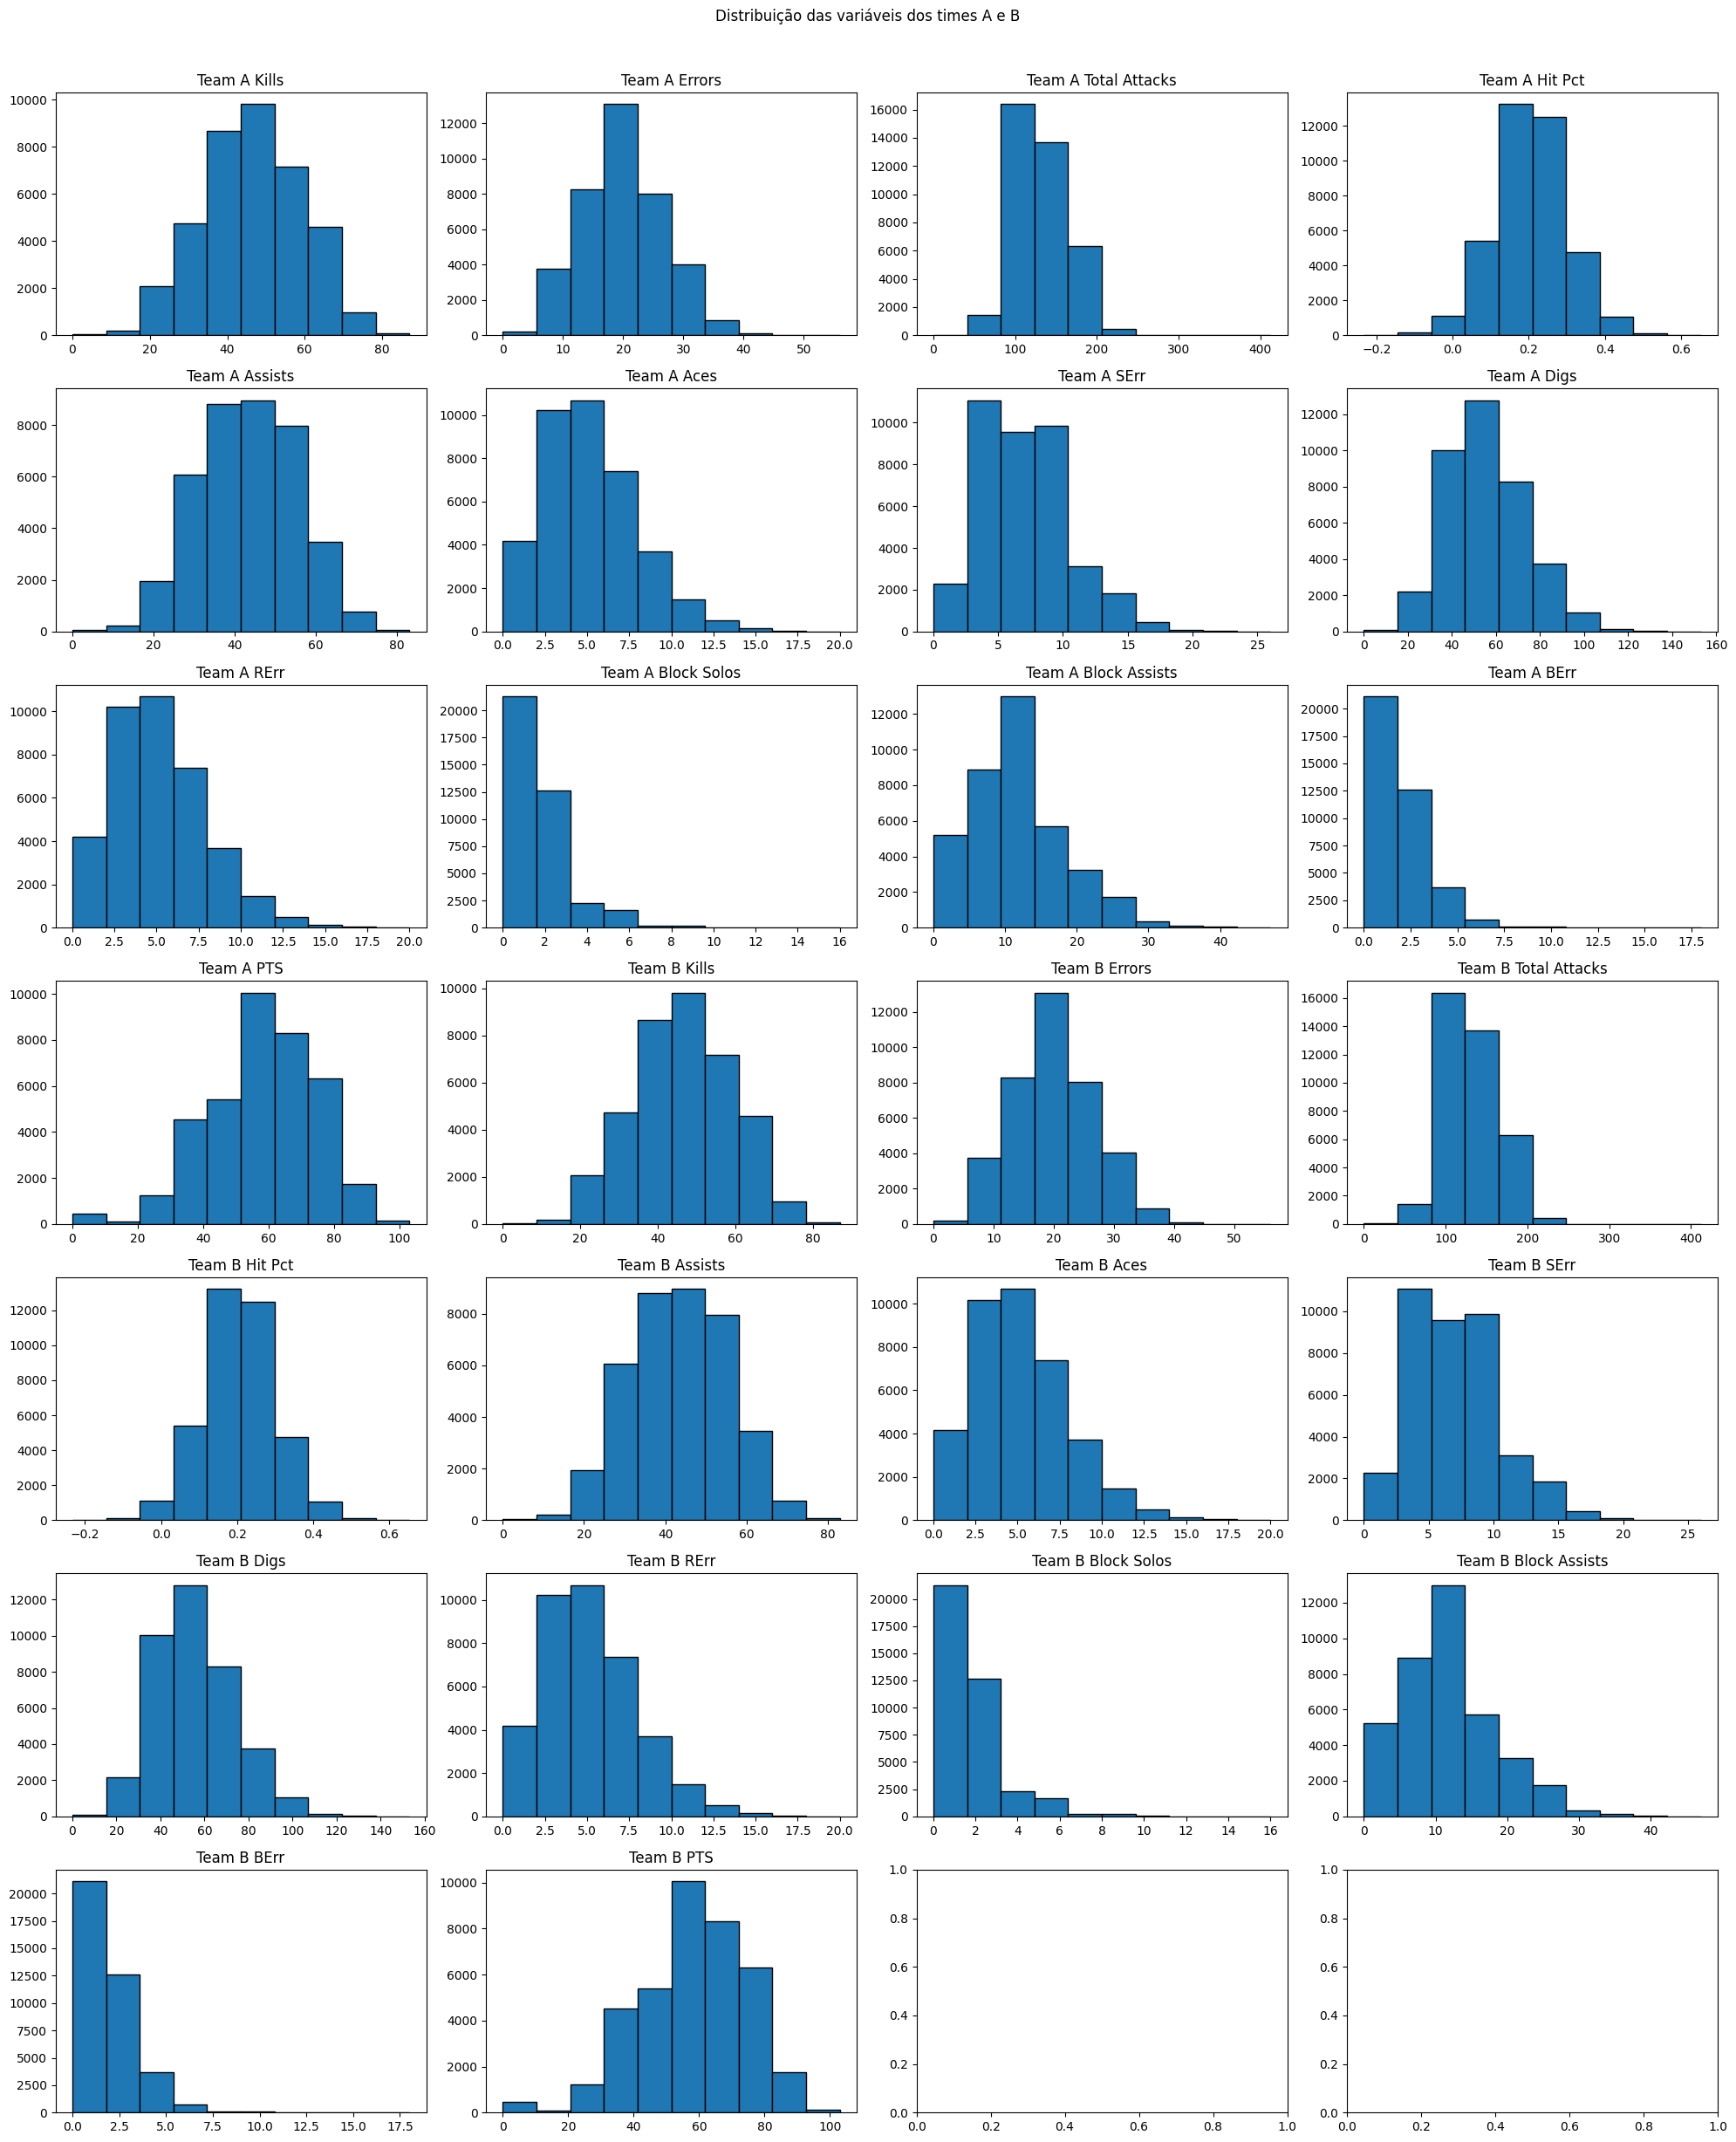

In [8]:
fig, axs = plt.subplots(7, 4, figsize=(20, 25))
fig.suptitle('Distribuição das variáveis dos times A e B')

colunas = df.columns

colunas_verify = [ 'Team A Kills',
       'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
       'Team A Assists', 'Team A Aces', 'Team A SErr', 'Team A Digs',
       'Team A RErr', 'Team A Block Solos', 'Team A Block Assists',
       'Team A BErr', 'Team A PTS', 'Team B Kills', 'Team B Errors',
       'Team B Total Attacks', 'Team B Hit Pct', 'Team B Assists',
       'Team B Aces', 'Team B SErr', 'Team B Digs', 'Team B RErr',
       'Team B Block Solos', 'Team B Block Assists', 'Team B BErr',
       'Team B PTS']

axs = axs.ravel()

for i, col in enumerate(colunas_verify):
    axs[i].hist(df[col], bins=10, edgecolor='black')
    axs[i].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### **Normalização**

In [9]:
scaler = MinMaxScaler()
df_norm = df
df_norm[colunas_verify] = scaler.fit_transform(df[colunas_verify])
df_norm

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
0,2019-08-30,USC Upstate,Virginia Tech,0,4.0,0.379310,0.375000,0.271845,0.384181,0.361446,...,0.461538,0.333333,0.20,0.2500,0.425532,0.111111,0.000000,247,158,-2906371336684792533
1,2019-08-30,USC Upstate,Northwestern,0,3.0,0.183908,0.428571,0.216019,0.161582,0.180723,...,0.269231,0.274510,0.05,0.1250,0.425532,0.000000,0.000000,247,32,7432467444798903436
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,0.425287,0.357143,0.283981,0.427119,0.421687,...,0.192308,0.320261,0.10,0.0625,0.127660,0.055556,0.485437,247,117,-6175680989212509423
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,0.574713,0.482143,0.398058,0.421469,0.566265,...,0.576923,0.437908,0.45,0.0625,0.361702,0.055556,0.684466,247,291,5653100916788619630
4,2019-09-14,USC Upstate,George Washington,0,3.0,0.344828,0.303571,0.271845,0.394350,0.361446,...,0.038462,0.392157,0.10,0.0625,0.127660,0.333333,0.504854,247,292,-3228531451885569381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,2016-10-29,Sacred Heart,Saint Francis,0,3.0,0.517241,0.321429,0.262136,0.545763,0.518072,...,0.076923,0.267974,0.35,0.0000,0.340426,0.055556,0.291262,194,18,-7890599992219718195
36920,2016-10-30,Fairleigh Dickinson,Saint Francis,1,5.0,0.505747,0.410714,0.398058,0.407910,0.457831,...,0.423077,0.581699,0.05,0.2500,0.212766,0.111111,0.660194,134,18,4440572172473690046
36921,2016-11-04,Robert Morris,Saint Francis,0,5.0,0.632184,0.339286,0.344660,0.550282,0.626506,...,0.384615,0.405229,0.40,0.0625,0.382979,0.111111,0.592233,167,18,-6878758415426025004
36922,2016-11-12,LIU,Saint Francis,0,4.0,0.655172,0.482143,0.385922,0.476836,0.590361,...,0.192308,0.431373,0.25,0.0625,0.212766,0.055556,0.582524,156,18,8707049060520557931


### **Vericando Outliers**

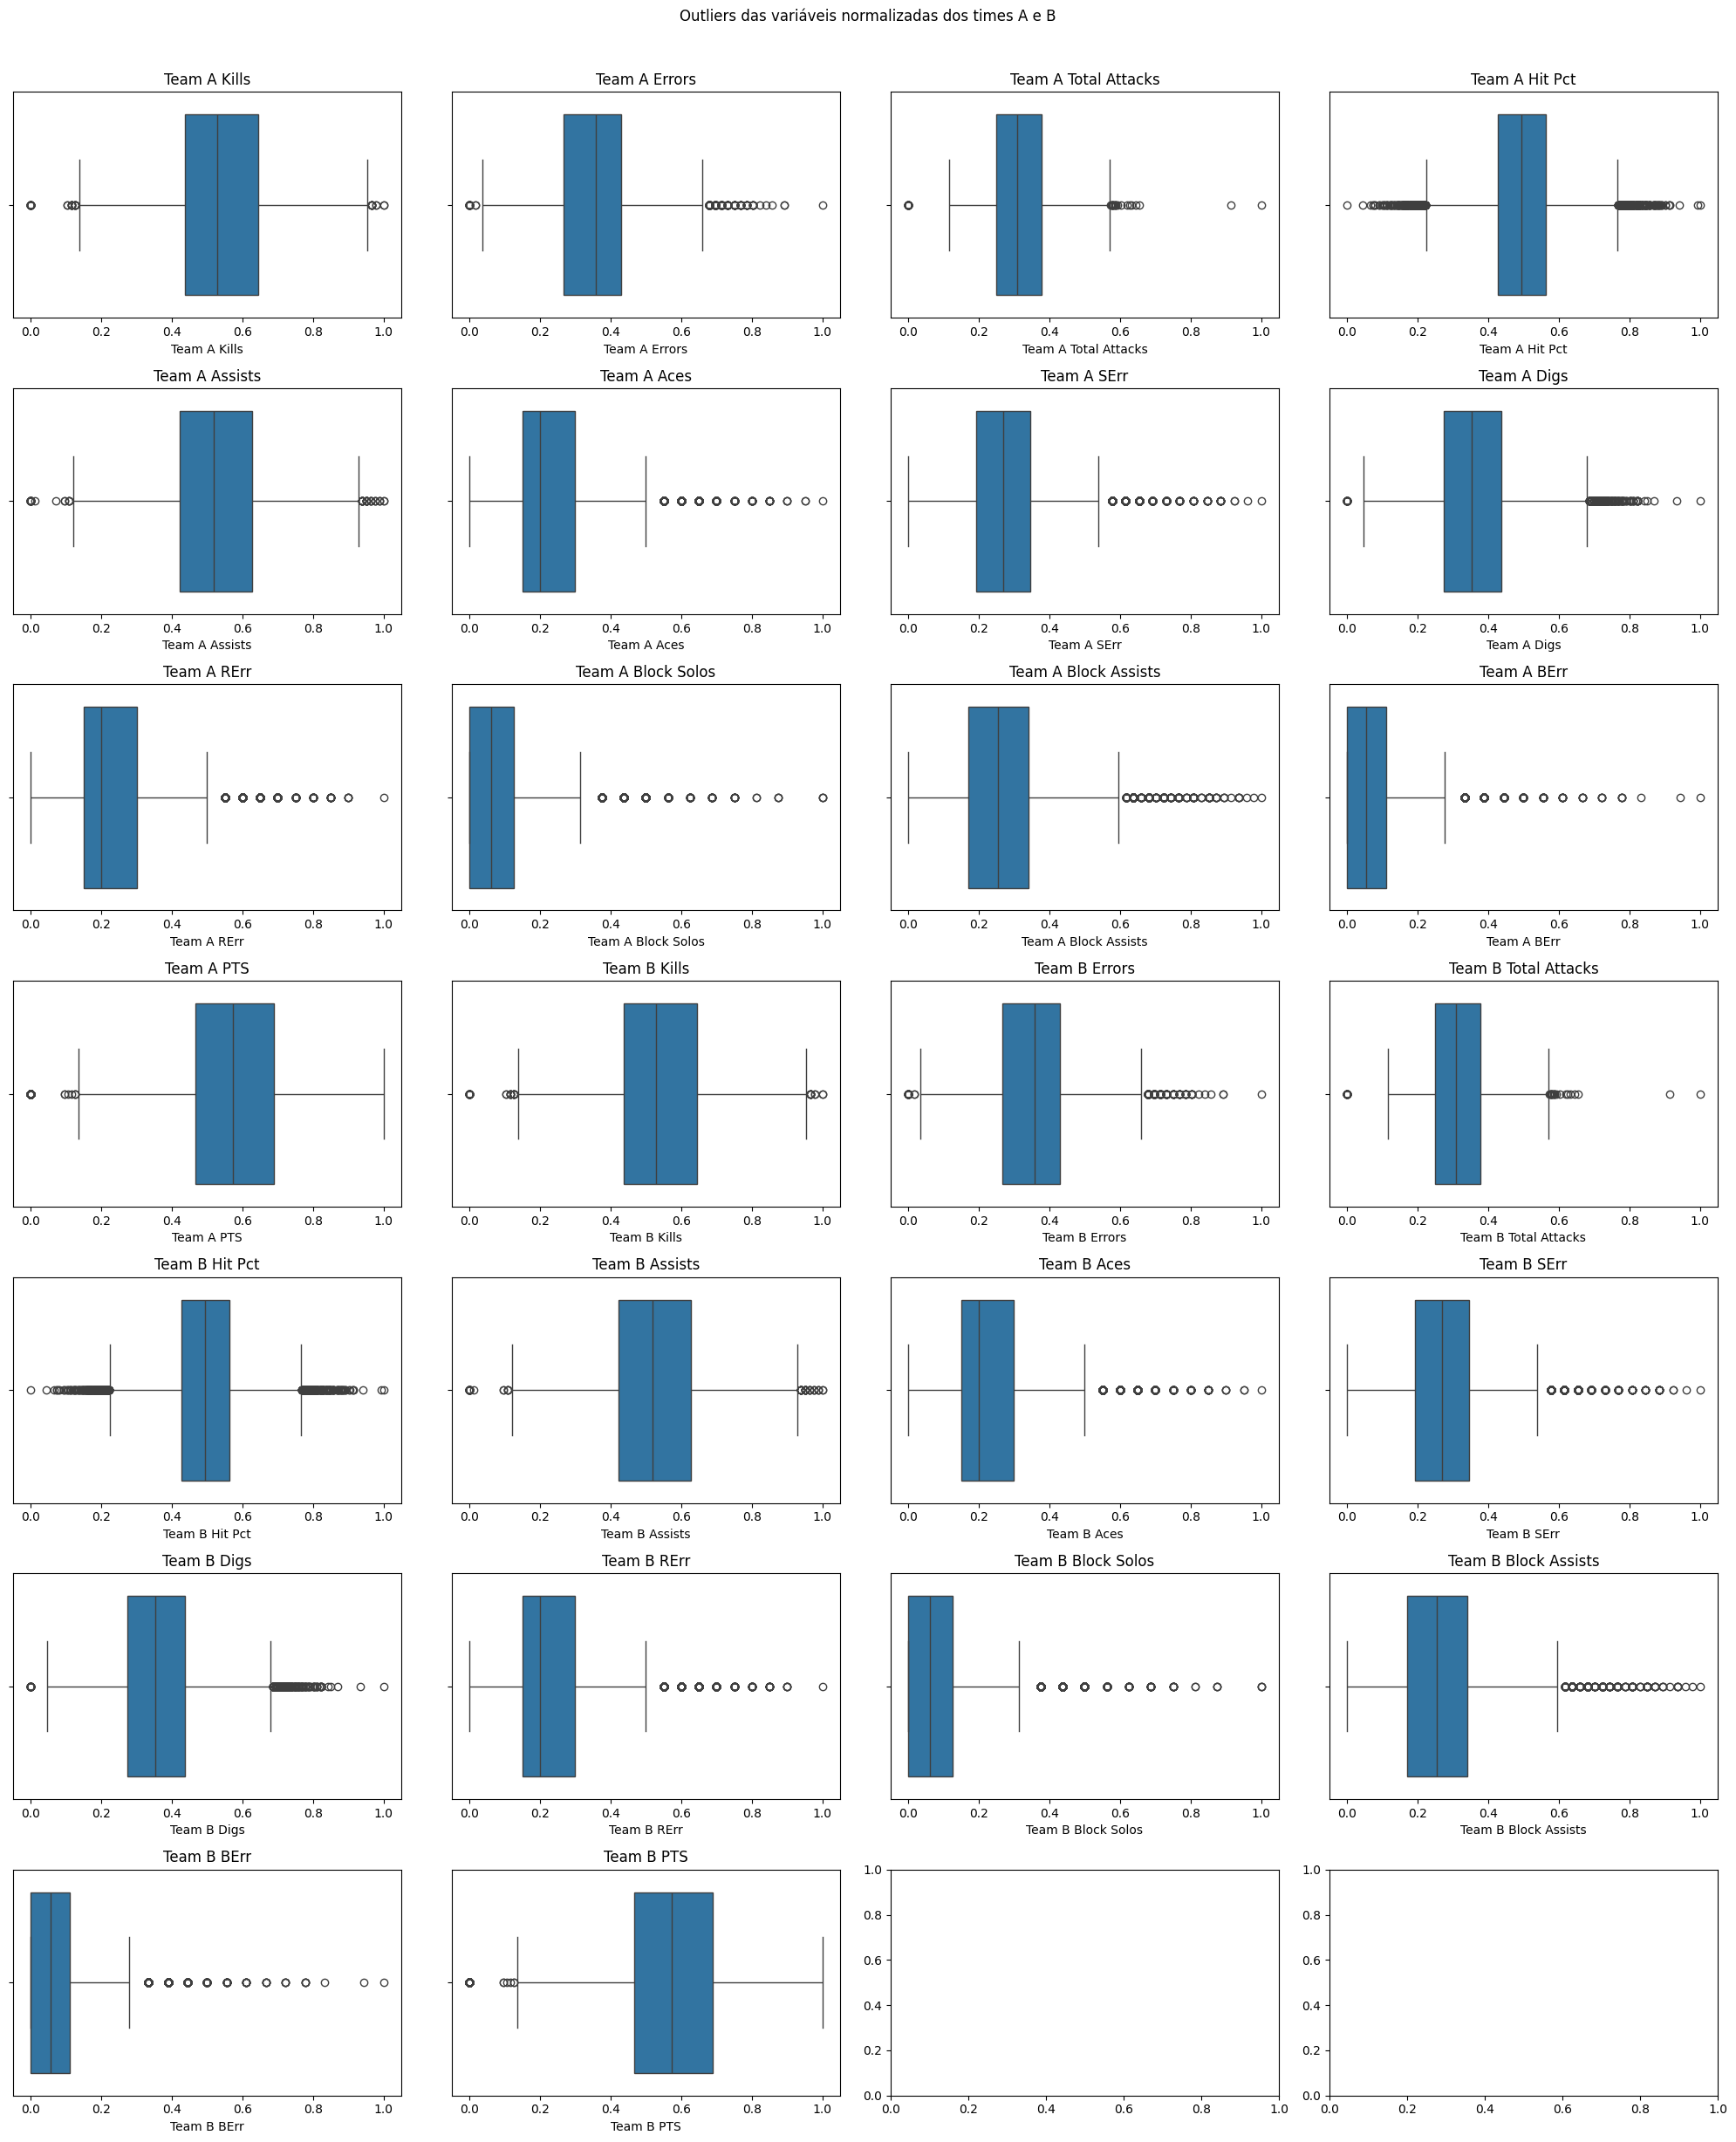

In [10]:
fig, axs = plt.subplots(7, 4, figsize=(20, 25))
fig.suptitle('Outliers das variáveis normalizadas dos times A e B')

axs = axs.ravel()

for i, col in enumerate(colunas_verify):
    sns.boxplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### **Retirada de Outliers via zscore**

In [12]:
z_scores = stats.zscore(df[colunas_verify])
df_norm_clean = df_norm[(abs(z_scores) < 3).all(axis=1)]

In [13]:
df_norm_clean.head()

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,0.425287,0.357143,0.283981,0.427119,0.421687,...,0.192308,0.320261,0.10,0.0625,0.127660,0.055556,0.485437,247,117,-6175680989212509423
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,0.574713,0.482143,0.398058,0.421469,0.566265,...,0.576923,0.437908,0.45,0.0625,0.361702,0.055556,0.684466,247,291,5653100916788619630
4,2019-09-14,USC Upstate,George Washington,0,3.0,0.344828,0.303571,0.271845,0.394350,0.361446,...,0.038462,0.392157,0.10,0.0625,0.127660,0.333333,0.504854,247,292,-3228531451885569381
5,2019-09-14,USC Upstate,East Carolina,0,5.0,0.666667,0.392857,0.407767,0.505085,0.686747,...,0.192308,0.496732,0.30,0.1250,0.170213,0.222222,0.815534,247,58,-747016456500487607
6,2019-09-17,USC Upstate,N.C. A&T,1,4.0,0.655172,0.303571,0.313107,0.613559,0.602410,...,0.615385,0.307190,0.15,0.1250,0.234043,0.000000,0.684466,247,230,7758528683864880479


## **Divisão de Features**
Divisão realizada baseado na apresentação utilizada de base sobre estatísticas de vôlei

OBS: Estou analisando aqui ainda, quais colunas do time B por

**Gerais**
* Date
* Team A/ID
* Team B/ID
* Result
* S
* Match ID

**Ataque**
* Team A Kills: Número de ataques que resultaram em pontos
* Team A Errors: Erros de ataque cometidos
* Team A Total Attacks: Total de ataques realizados
* Team A Hit Pct: Percentual de acerto no ataque
* Team A Assists: Assistências para ataque

**Saque**
* Team A Aces: Pontos diretos de saque
* Team A SErr: Erros de saque

**Defesa**
* Team A Digs: Defesas bem-sucedidas
* Team A RErr: Erros de recepção

**Bloqueio**
* Team A Block Solos: Bloqueios individuais
* Team A Block Assists: Assistências em bloqueios
* Team A BErr: Erros de bloqueio

### **Dividindo Dataframe pelas categorias**

In [82]:
# Ataque
colunas_atq = [ 'Team A Kills',
       'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
       'Team A Assists']
df_atq = df_norm_clean[colunas_atq]
correlation_matrix_atq = df_atq.corr()

# Saque
colunas_saq = ['Team A Aces', 'Team A SErr']
df_saq = df_norm_clean[colunas_saq]
correlation_matrix_saq = df_saq.corr()

# Defesa
colunas_def = ['Team A Digs', 'Team A RErr']
df_def = df_norm_clean [colunas_def]
correlation_matrix_def = df_def.corr()

#Bloqueio
colunas_bloq = ['Team A Block Solos', 'Team A Block Assists', 'Team A BErr']
df_bloq = df_norm_clean [colunas_bloq]
correlation_matrix_bloq = df_bloq.corr()

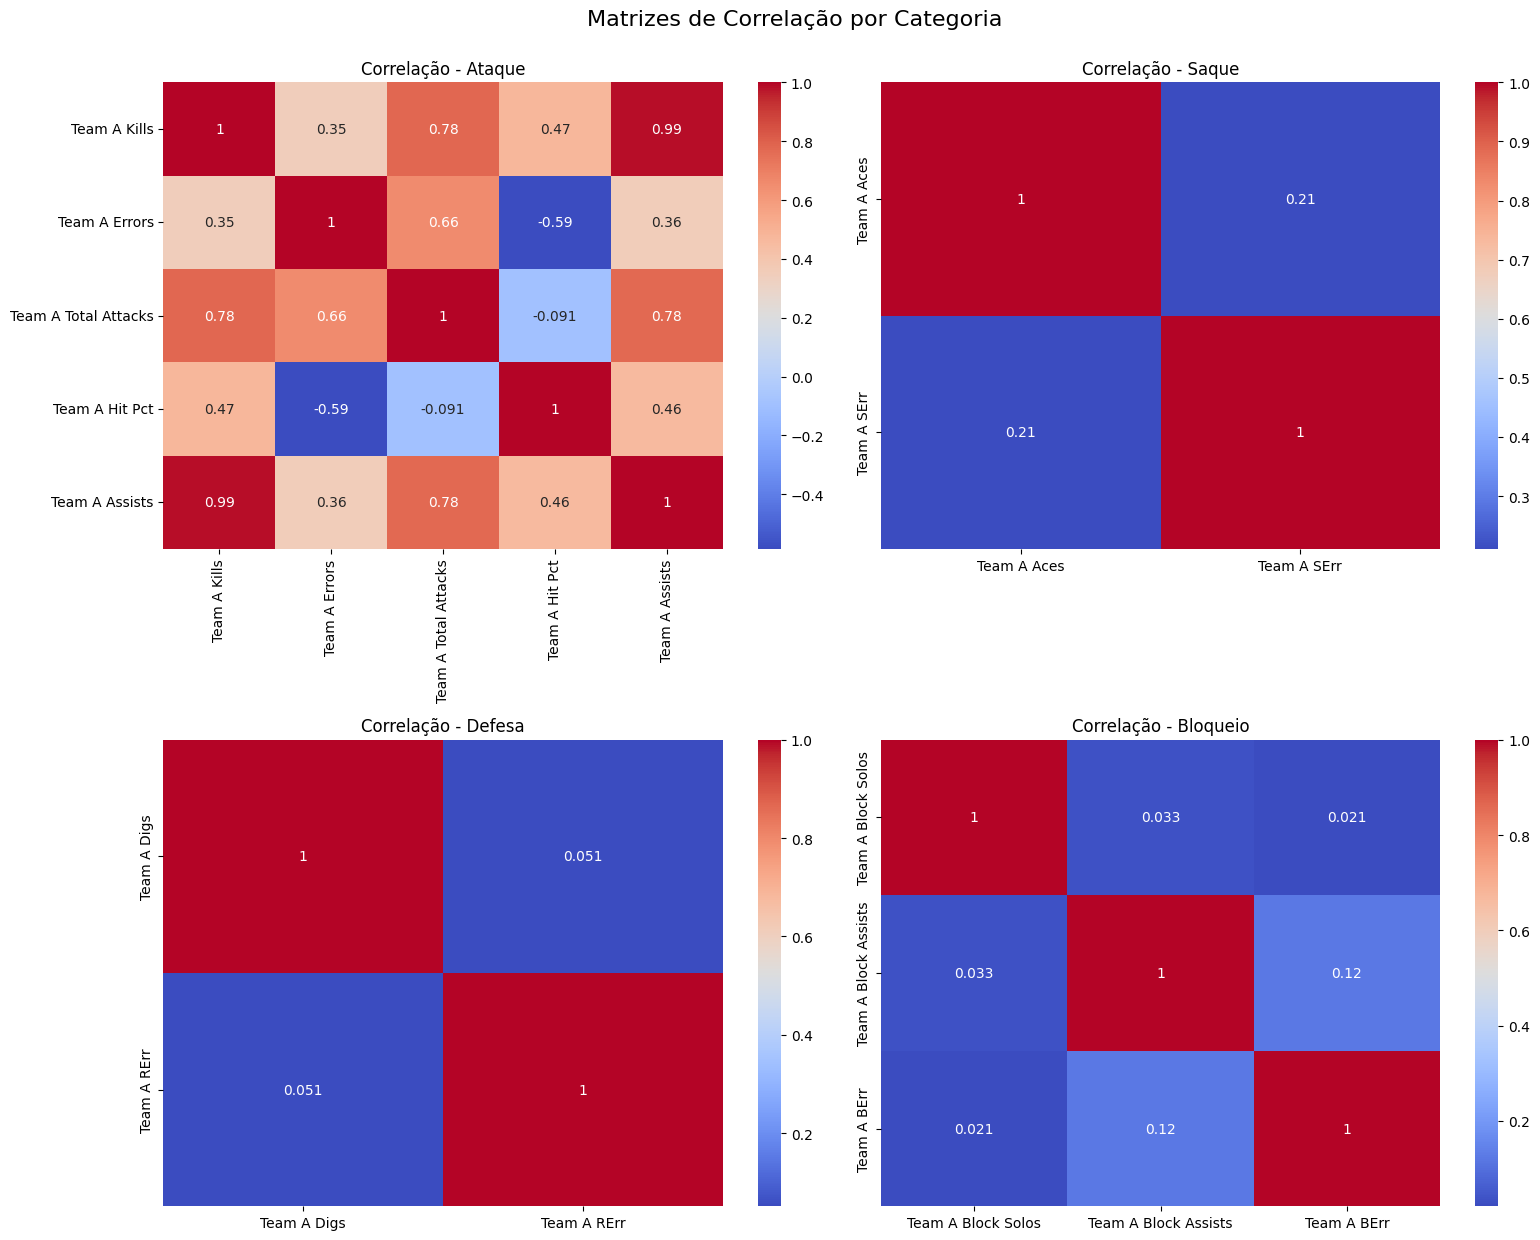

In [87]:
# Criando a figura com 2 linhas e 2 colunas de subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plotando o heatmap para Ataque
sns.heatmap(correlation_matrix_atq, annot=True, cmap='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('Correlação - Ataque')

# Plotando o heatmap para Saque
sns.heatmap(correlation_matrix_saq, annot=True, cmap='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Correlação - Saque')

# Plotando o heatmap para Defesa
sns.heatmap(correlation_matrix_def, annot=True, cmap='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Correlação - Defesa')

# Plotando o heatmap para Bloqueio
sns.heatmap(correlation_matrix_bloq, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Correlação - Bloqueio')

# Ajustando o layout para melhorar a visualização
plt.tight_layout()

# Adicionando o título geral da figura
fig.suptitle('Matrizes de Correlação por Categoria', fontsize=16, y=1.03)

# Exibindo a figura
plt.show()


### **Retirando Colunas com Alta Correlação**

In [15]:
df_atq = df_atq.drop(columns=['Team A Assists'])

In [19]:
df_atq.head()

,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct
2,0.425287,0.357143,0.283981,0.427119
3,0.574713,0.482143,0.398058,0.421469
4,0.344828,0.303571,0.271845,0.394350
5,0.666667,0.392857,0.407767,0.505085
6,0.655172,0.303571,0.313107,0.613559


In [20]:
df_saq.head()

,Team A Aces,Team A SErr
2,0.10,0.153846
3,0.45,0.230769
4,0.10,0.230769
5,0.30,0.230769
6,0.15,0.384615


In [21]:
df_def.head()

,Team A Digs,Team A RErr
2,0.313725,0.20
3,0.496732,0.55
4,0.274510,0.15
5,0.418301,0.40
6,0.352941,0.40


In [22]:
df_bloq.head()

,Team A Block Solos,Team A Block Assists,Team A BErr
2,0.2500,0.042553,0.111111
3,0.1250,0.425532,0.000000
4,0.0000,0.255319,0.000000
5,0.0625,0.276596,0.055556
6,0.0000,0.425532,0.000000


### **Teste Preliminar: KMeans**
Testei inicialmente fazer semelhante ao que fizeram no artigo de base de rodas os testes do kmens com n até no máximo o valor total de features daquela categoria. Mas os resultados deram péssimos, então testei até 5 clusters.

In [36]:
def kmeans_categoria(df):
    range_n_clusters = range(2, 6)
    silhouette = []
    davies_bouldin = []
    inertia = []

    for n_clusters in range_n_clusters:

        kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
        kmeans.fit(df)
        labels = kmeans.labels_

        silhouette.append((n_clusters, silhouette_score(df, labels)))
        davies_bouldin.append((n_clusters, davies_bouldin_score(df, labels)))
        inertia.append((n_clusters, kmeans.inertia_))

    return davies_bouldin, silhouette, inertia


#### **KMeans para Ataque**

In [37]:
db_atq, sl_atq, in_atq = kmeans_categoria(df_atq)
atq = {'Categoria': 'Ataque','Silhouette-Score':sl_atq,'Davies-Bouldin-Score':db_atq, 'Inertia': in_atq}
atq

{'Categoria': 'Ataque',
 'Silhouette-Score': [(2, 0.37419759704688715),
  (3, 0.4061048383796767),
  (4, 0.35556009765263735),
  (5, 0.334018767954981)],
 'Davies-Bouldin-Score': [(2, 1.0591843561622039),
  (3, 0.8308587243471764),
  (4, 0.9952221159150214),
  (5, 0.9617787233817175)],
 'Inertia': [(2, 995.81258870197),
  (3, 611.85563702081),
  (4, 504.9101997206549),
  (5, 425.249863388928)]}

#### **KMeans para Bloqueio**

In [38]:
db_bloq, sl_bloq, in_bloq = kmeans_categoria(df_bloq)
bloq = {'Categoria': 'Bloqueio','Silhouette-Score':sl_bloq,'Davies-Bouldin-Score':db_bloq, 'Inertia':in_bloq}
bloq


{'Categoria': 'Bloqueio',
 'Silhouette-Score': [(2, 0.3354273651565811),
  (3, 0.29474706214457597),
  (4, 0.2621317487663363),
  (5, 0.2783494871904884)],
 'Davies-Bouldin-Score': [(2, 1.178179160748456),
  (3, 1.253171974678415),
  (4, 1.2117757749611484),
  (5, 1.0513034906783005)],
 'Inertia': [(2, 670.02266466773),
  (3, 544.9528643759646),
  (4, 456.8503251960275),
  (5, 385.2410600516555)]}

#### **KMeans para Defesa**

In [39]:
db_def, sl_def, in_def = kmeans_categoria(df_def)
de = {'Categoria': 'Defesa','Silhouette-Score':sl_def,'Davies-Bouldin-Score':db_def,'Inertia': in_def}
de

{'Categoria': 'Defesa',
 'Silhouette-Score': [(2, 0.3655296461922304),
  (3, 0.3784531859230462),
  (4, 0.3590234607601021),
  (5, 0.34908909009803046)],
 'Davies-Bouldin-Score': [(2, 1.1118437008096946),
  (3, 0.9073394708779653),
  (4, 0.9268212649859333),
  (5, 0.8922539093330455)],
 'Inertia': [(2, 607.2094555007895),
  (3, 404.3168945727077),
  (4, 316.12896586784666),
  (5, 255.32064342463292)]}

#### **KMeans para Saque**

In [40]:
db_saq, sl_saq, in_saq = kmeans_categoria(df_saq)
saq = {'Categoria': 'Saque','Silhouette-Score':sl_saq,'Davies-Bouldin-Score':db_saq,'Inertia': in_saq}
saq

{'Categoria': 'Saque',
 'Silhouette-Score': [(2, 0.36982644277390353),
  (3, 0.3676802099022779),
  (4, 0.35572931732420077),
  (5, 0.33852289358509197)],
 'Davies-Bouldin-Score': [(2, 1.079694907047095),
  (3, 0.9606277297478706),
  (4, 0.9040078671031206),
  (5, 0.898960409181076)],
 'Inertia': [(2, 629.0543796036322),
  (3, 442.3289346062468),
  (4, 339.1540255588937),
  (5, 282.4561696088021)]}

#### **Análise de Resultados**

In [45]:
dados = []
casos = [saq,de,atq,bloq]

for caso in casos:
    for sl_tupla, db_tupla, in_tupla in zip(caso['Silhouette-Score'], caso['Davies-Bouldin-Score'],caso['Inertia']):
        n_clusters = sl_tupla[0]
        sl_score = sl_tupla[1]
        db_score = db_tupla[1]
        inertia = in_tupla[1]

        

        dados.append({
            'Categoria': caso['Categoria'],
            'n clusters': n_clusters,
            'Silhouette Score': sl_score,
            'Davies-Bouldin Score': db_score,
            'Inertia':  inertia
        })
resultados = pd.DataFrame(dados)

def highlight_specific_row(row):
    if row.name in [5, 2,9 ,12 ]:
        return ['background-color: green'] * len(row)
    else:
        return [''] * len(row)


styled_df = resultados.style.apply(highlight_specific_row, axis=1)

styled_df

,Categoria,n clusters,Silhouette Score,Davies-Bouldin Score,Inertia
0,Saque,2,0.369826,1.079695,629.054380
1,Saque,3,0.367680,0.960628,442.328935
2,Saque,4,0.355729,0.904008,339.154026
3,Saque,5,0.338523,0.898960,282.456170
4,Defesa,2,0.365530,1.111844,607.209456
5,Defesa,3,0.378453,0.907339,404.316895
6,Defesa,4,0.359023,0.926821,316.128966
7,Defesa,5,0.349089,0.892254,255.320643
8,Ataque,2,0.374198,1.059184,995.812589
9,Ataque,3,0.406105,0.830859,611.855637


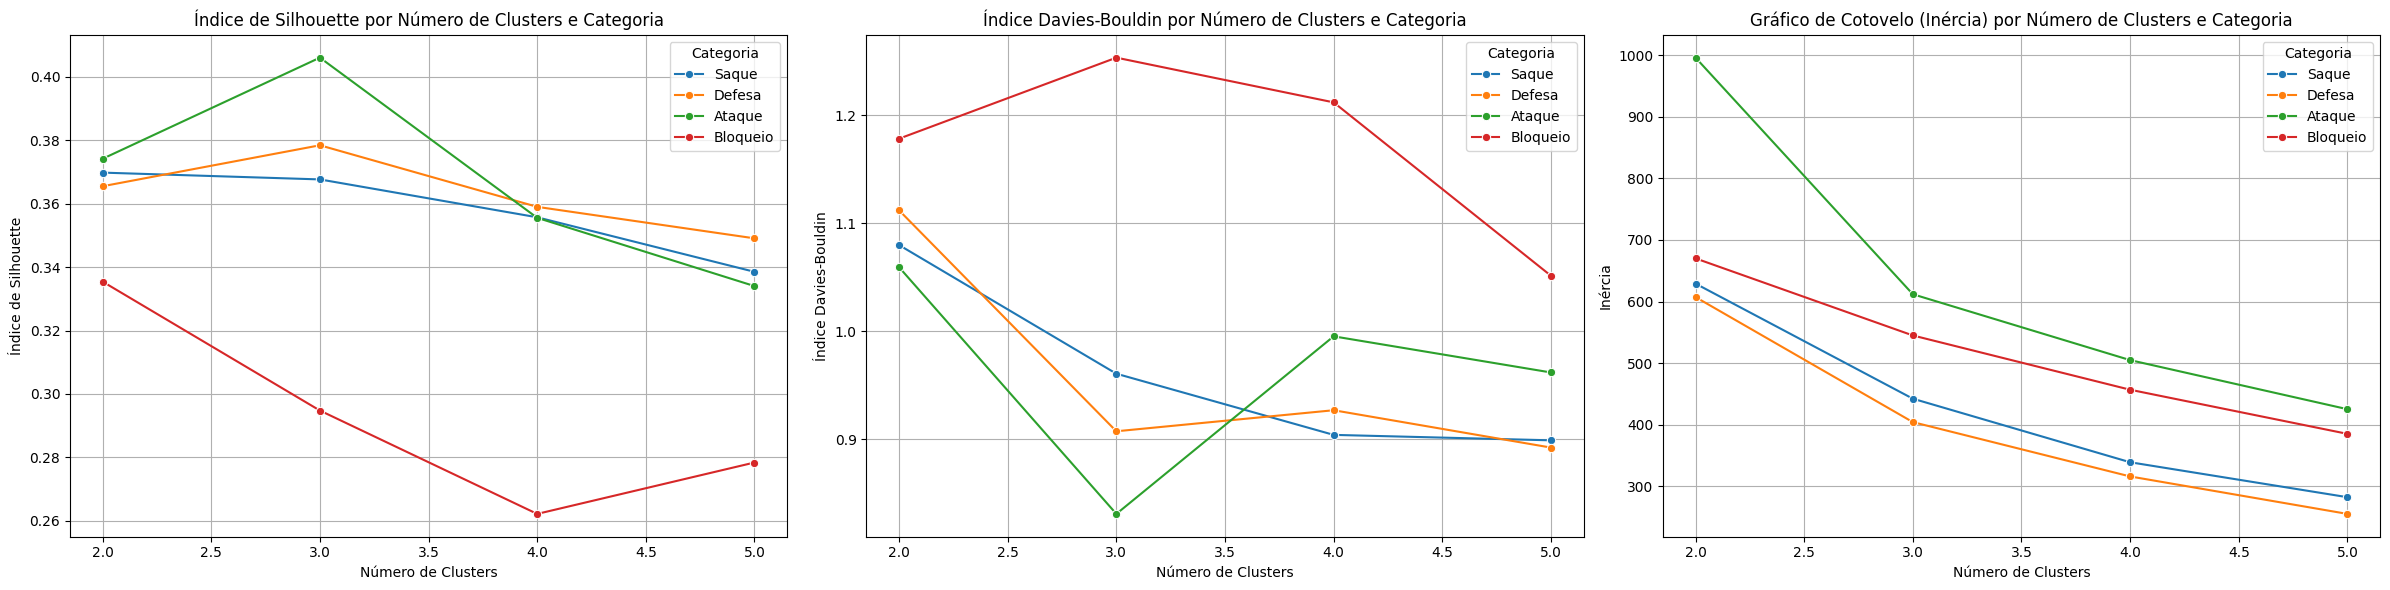

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Gráfico de Silhouette
sns.lineplot(x='n clusters', y='Silhouette Score', hue='Categoria', marker='o', data=resultados, ax=axes[0])
axes[0].set_title('Índice de Silhouette por Número de Clusters e Categoria')
axes[0].set_xlabel('Número de Clusters')
axes[0].set_ylabel('Índice de Silhouette')
axes[0].legend(title='Categoria')
axes[0].grid(True)

# Gráfico de Davies-Bouldin
sns.lineplot(x='n clusters', y='Davies-Bouldin Score', hue='Categoria', marker='o', data=resultados, ax=axes[1])
axes[1].set_title('Índice Davies-Bouldin por Número de Clusters e Categoria')
axes[1].set_xlabel('Número de Clusters')
axes[1].set_ylabel('Índice Davies-Bouldin')
axes[1].legend(title='Categoria')
axes[1].grid(True)

# Gráfico de Inércia (Cotovelo)
sns.lineplot(x='n clusters', y='Inertia', hue='Categoria', marker='o', data=resultados, ax=axes[2])
axes[2].set_title('Gráfico de Cotovelo (Inércia) por Número de Clusters e Categoria')
axes[2].set_xlabel('Número de Clusters')
axes[2].set_ylabel('Inércia')
axes[2].legend(title='Categoria')
axes[2].grid(True)

plt.tight_layout()
plt.show()

### **Visualização Gráfica**

In [ ]:
# Ataque
df_atq_cluster = df_atq
kmeans = KMeans(n_clusters=3)
df_atq_cluster['Cluster'] = kmeans.fit_predict(df_atq_cluster[['Team A Kills', 'Team A Errors']])

# Bloqueio
df_bloq_cluster = df_bloq
kmeans = KMeans(n_clusters=2)
df_bloq_cluster['Cluster'] = kmeans.fit_predict(df_bloq_cluster[['Team A Block Assists', 'Team A BErr']])

# Defesa
df_def_cluster = df_def
kmeans = KMeans(n_clusters=3)
df_def_cluster['Cluster'] = kmeans.fit_predict(df_def_cluster[['Team A Digs', 'Team A RErr']])

# Saque
df_saq_cluster = df_saq
kmeans = KMeans(n_clusters=4)
df_saq_cluster['Cluster'] = kmeans.fit_predict(df_saq_cluster[['Team A Aces', 'Team A SErr']])

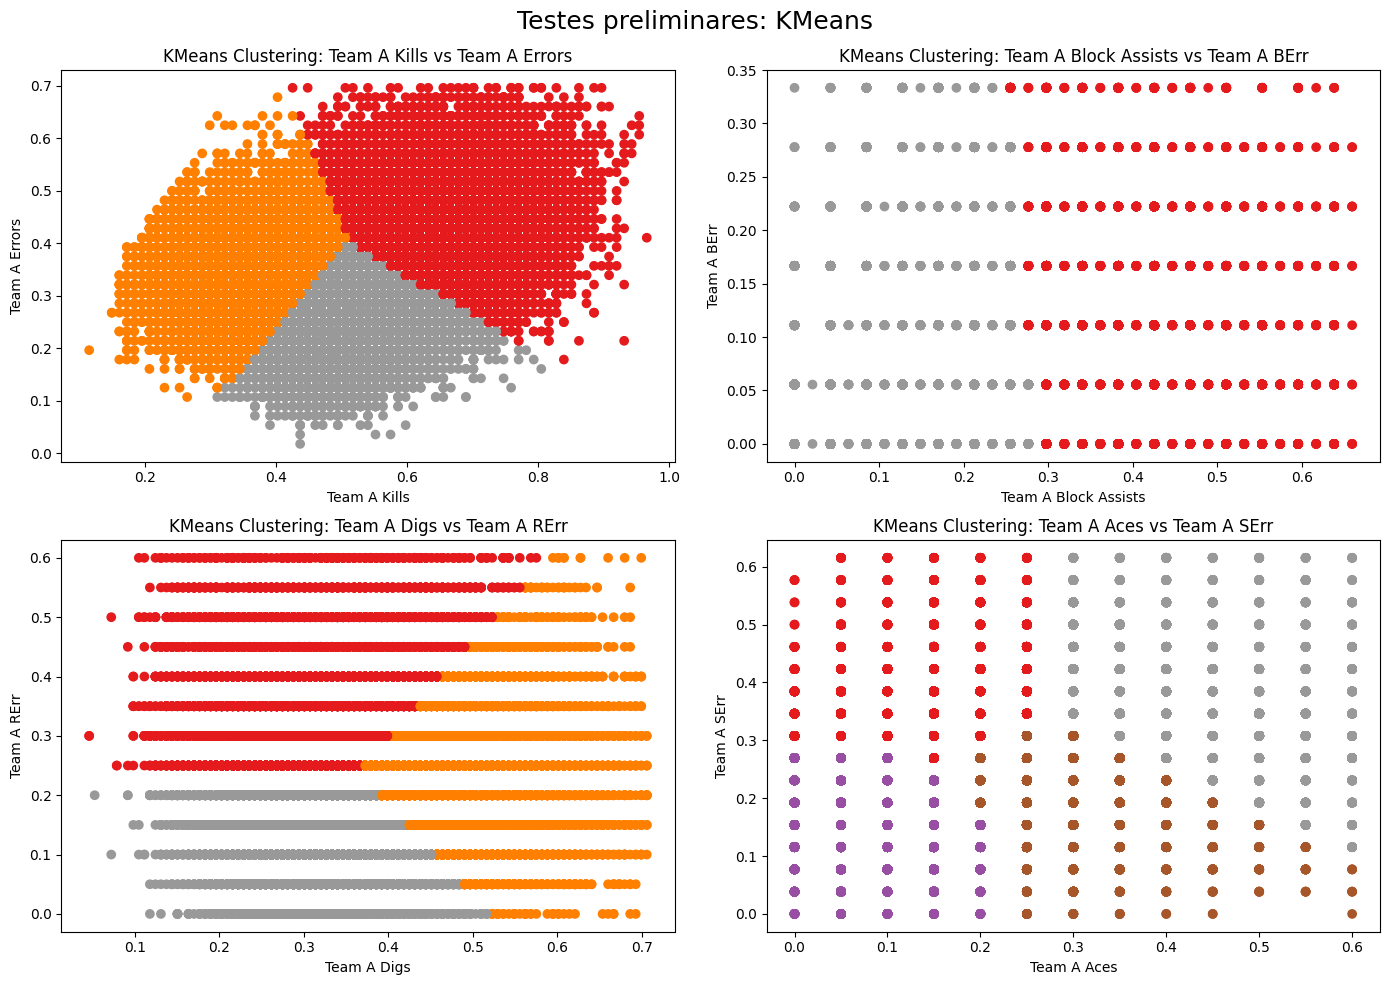

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico Ataque
axes[0, 0].scatter(df_atq_cluster['Team A Kills'], df_atq_cluster['Team A Errors'], 
                   c=df_atq_cluster['Cluster'], cmap='Set1')
axes[0, 0].set_xlabel('Team A Kills')
axes[0, 0].set_ylabel('Team A Errors')
axes[0, 0].set_title('KMeans Clustering: Team A Kills vs Team A Errors')

# Gráfico Bloqueio
axes[0, 1].scatter(df_bloq_cluster['Team A Block Assists'], df_bloq_cluster['Team A BErr'], 
                   c=df_bloq_cluster['Cluster'], cmap='Set1')
axes[0, 1].set_xlabel('Team A Block Assists')
axes[0, 1].set_ylabel('Team A BErr')
axes[0, 1].set_title('KMeans Clustering: Team A Block Assists vs Team A BErr')

# Gráfico Defesa
axes[1, 0].scatter(df_def_cluster['Team A Digs'], df_def_cluster['Team A RErr'], 
                   c=df_def_cluster['Cluster'], cmap='Set1')
axes[1, 0].set_xlabel('Team A Digs')
axes[1, 0].set_ylabel('Team A RErr')
axes[1, 0].set_title('KMeans Clustering: Team A Digs vs Team A RErr')

# Gráfico Saque
axes[1, 1].scatter(df_saq_cluster['Team A Aces'], df_saq_cluster['Team A SErr'], 
                   c=df_saq_cluster['Cluster'], cmap='Set1')
axes[1, 1].set_xlabel('Team A Aces')
axes[1, 1].set_ylabel('Team A SErr')
axes[1, 1].set_title('KMeans Clustering: Team A Aces vs Team A SErr')


plt.tight_layout()
fig.suptitle('Testes preliminares: KMeans', fontsize=18)
plt.subplots_adjust(wspace=0.15, hspace=0.20,top=0.92)
plt.show()


### **Conclusões**

Pelos padrões que estudamos os resultados estão consideravelmente ruins, mas os outros casos mostrados na literatura demonstram resultados muitas vezes piores com scores de davies-bouldin indo até 4 e superior

### **Analisando Porcentagem de Ganho de Partidas**

In [ ]:
x = df_norm_clean

x['cl atq'] = df_atq_cluster['Cluster']
x['cl def'] = df_def_cluster['Cluster']
x['cl bloq'] = df_bloq_cluster['Cluster']
x['cl saq'] = df_saq_cluster['Cluster']

In [ ]:
duplicated_matches = x[x.duplicated(subset=['Match_ID'], keep=False)]

# Para cada Match_ID duplicado, pegar os valores do primeiro e do segundo registros
for match_id in duplicated_matches['Match_ID'].unique():
    # Filtrar os registros com o mesmo Match_ID
    same_match = x[x['Match_ID'] == match_id]
    
    # Pegar o primeiro e o segundo registros
    first_row_index = same_match.index[0]
    second_row_index = same_match.index[1]
    
    # Pegar os valores do segundo registro e adicionar ao primeiro com novos nomes
    x.loc[first_row_index, 'cl atq B'] = x.loc[second_row_index, 'cl atq']
    x.loc[first_row_index, 'cl def B'] = x.loc[second_row_index, 'cl def']
    x.loc[first_row_index, 'cl bloq B'] = x.loc[second_row_index, 'cl bloq']
    x.loc[first_row_index, 'cl saq B'] = x.loc[second_row_index, 'cl saq']
    
    # Pegar os valores do primeiro registro e adicionar ao segundo com novos nomes
    x.loc[second_row_index, 'cl atq B'] = x.loc[first_row_index, 'cl atq']
    x.loc[second_row_index, 'cl def B'] = x.loc[first_row_index, 'cl def']
    x.loc[second_row_index, 'cl bloq B'] = x.loc[first_row_index, 'cl bloq']
    x.loc[second_row_index, 'cl saq B'] = x.loc[first_row_index, 'cl saq']

In [56]:
def calcula_aproveitamento(n,col,x):
    lst = {}
    for i in range(n):
        so_i = x[(x[col] == i)]

        for j in range(n):
            df_ij = so_i[so_i[f'{col} B'] == j]
            df_ij
            total_partidas = df_ij.shape[0]
            if total_partidas != 0:
                df_ij_vit = df_ij[df_ij['Result']==1]
                total_vitorias = df_ij_vit.shape[0]
                lst[f'{i}x{j}'] = total_vitorias/total_partidas
            else:
                print(f'para {i} e {j} total de partidas deu 0 no cluster de {col}')
    return lst

apv_atq = calcula_aproveitamento(3,'cl atq',x)
apv_bloq = calcula_aproveitamento(2,'cl bloq',x)
apv_saq = calcula_aproveitamento(4,'cl saq',x)
apv_def = calcula_aproveitamento(3,'cl def',x)

#### **Porcentagem de Vitórias por Matchup**

In [65]:
heatmap_atq = pd.DataFrame(index=[0, 1, 2], columns=[0, 1, 2])
for key, value in apv_atq.items():
    i, j = map(int, key.split('x'))
    heatmap_atq.at[i, j] = value
heatmap_atq = heatmap_atq.astype(float)

heatmap_bloq = pd.DataFrame(index=[0, 1], columns=[0, 1])
for key, value in apv_bloq.items():
    i, j = map(int, key.split('x'))
    heatmap_bloq.at[i, j] = value
heatmap_bloq = heatmap_bloq.astype(float)

heatmap_def = pd.DataFrame(index=[0, 1], columns=[0, 1])
for key, value in apv_def.items():
    i, j = map(int, key.split('x'))
    heatmap_def.at[i, j] = value
heatmap_def = heatmap_def.astype(float)

heatmap_saq = pd.DataFrame(index=[0, 1], columns=[0, 1])
for key, value in apv_saq.items():
    i, j = map(int, key.split('x'))
    heatmap_saq.at[i, j] = value
heatmap_saq = heatmap_saq.astype(float)

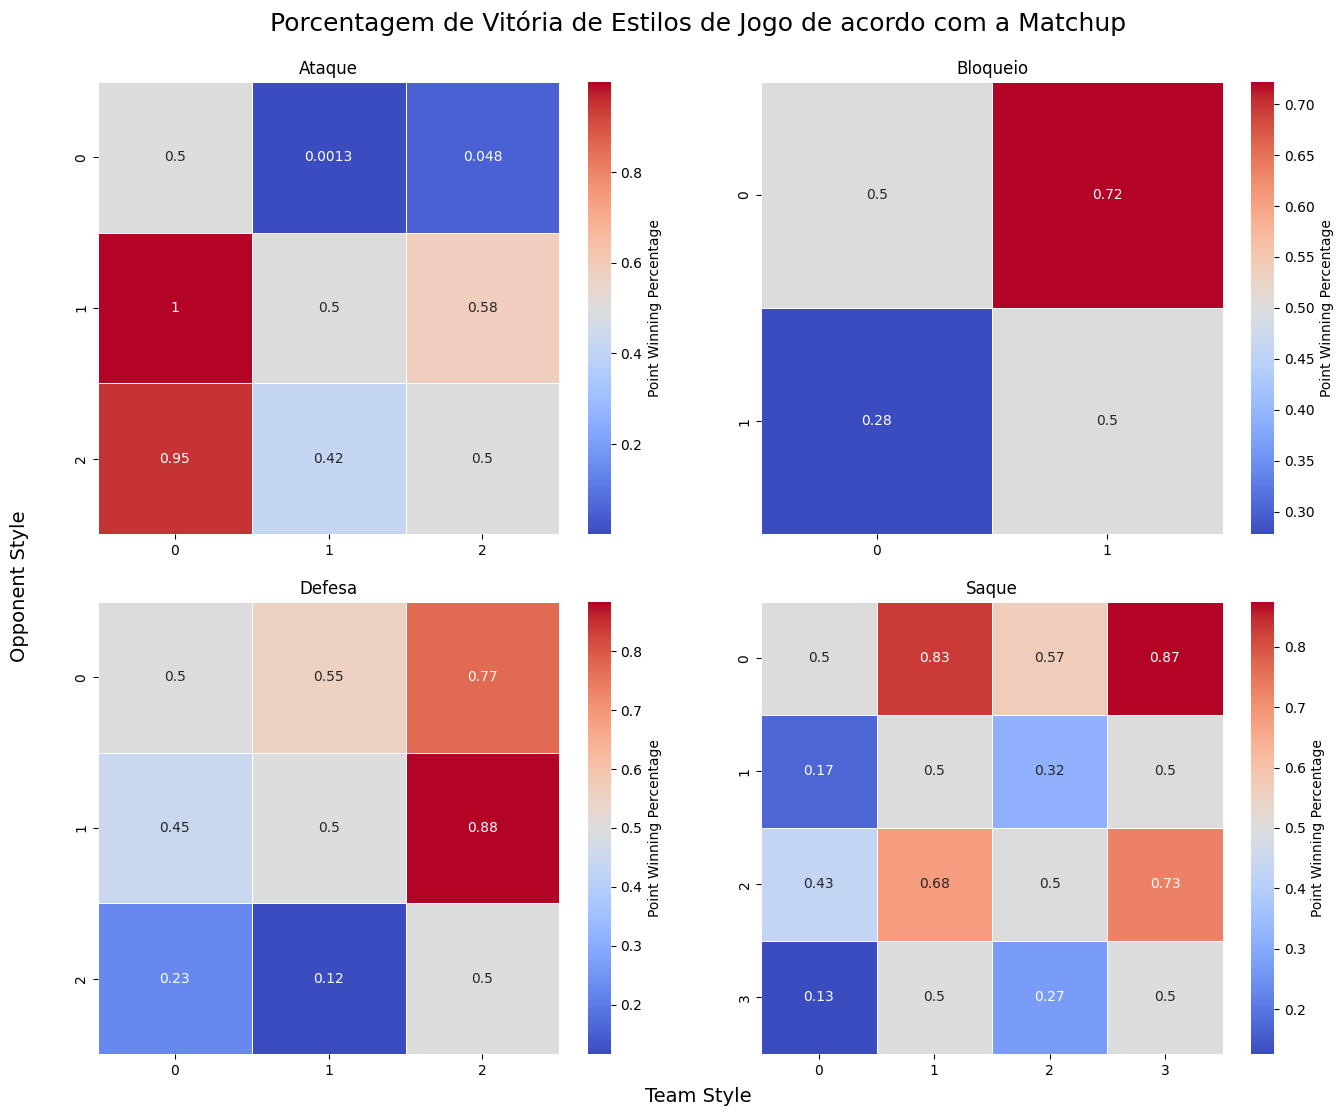

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.heatmap(heatmap_atq, annot=True, cmap='coolwarm',linewidth=.5,cbar_kws={"label": "Point Winning Percentage"} ,ax=axes[0, 0])
sns.heatmap(heatmap_bloq, annot=True, cmap='coolwarm',linewidth=.5,cbar_kws={"label": "Point Winning Percentage"} ,ax=axes[0, 1])
sns.heatmap(heatmap_def, annot=True, cmap='coolwarm',linewidth=.5,cbar_kws={"label": "Point Winning Percentage"} ,ax=axes[1, 0])
sns.heatmap(heatmap_saq, annot=True, cmap='coolwarm',linewidth=.5,cbar_kws={"label": "Point Winning Percentage"} ,ax=axes[1, 1])

axes[0, 0].set_title('Ataque')
axes[0, 1].set_title('Bloqueio')
axes[1, 0].set_title('Defesa')
axes[1, 1].set_title('Saque')

fig.text(0.5, 0.07, 'Team Style', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'Opponent Style', va='center', rotation='vertical', fontsize=14)

fig.suptitle('Porcentagem de Vitória de Estilos de Jogo de acordo com a Matchup', fontsize=18)

plt.subplots_adjust(wspace=0.15, hspace=0.15,top=0.92)

plt.show()

## **Estilos Completos**

### **Porcentagem de Vitória por Matchup de Estilos Completos**

In [ ]:
x['Estilo Completo'] = x.apply(lambda row: f"{row['cl atq']}{row['cl def']}{row['cl bloq']}{row['cl saq']}", axis=1)
x = x.dropna(subset=['cl def B'])
x['Estilo Completo B'] = x.apply(lambda row: f"{int(row['cl atq B'])}{int(row['cl def B'])}{int(row['cl bloq B'])}{int(row['cl saq B'])}", axis=1)


In [68]:
df_unique = x.drop_duplicates(subset='Match_ID', keep='first')

resultado_agrupado = x.groupby(['Estilo Completo', 'Estilo Completo B']).agg(
    total_partidas=('Result', 'size'),
    total_vitorias=('Result', 'sum')
).reset_index()

# Calcular a porcentagem de vitórias
resultado_agrupado['porcentagem_vitorias'] = (resultado_agrupado['total_vitorias'] / resultado_agrupado['total_partidas'])
resultado_agrupado

,Estilo Completo,Estilo Completo B,total_partidas,total_vitorias,porcentagem_vitorias
0,0000,0000,1,0,0.000000
1,0000,0010,1,1,1.000000
2,0000,0200,1,0,0.000000
3,0000,0201,1,1,1.000000
4,0000,0203,1,1,1.000000
...,...,...,...,...,...
2635,2213,2112,3,1,0.333333
2636,2213,2200,5,2,0.400000
2637,2213,2202,2,1,0.500000
2638,2213,2210,3,1,0.333333


In [69]:
resultado_agrupado = resultado_agrupado.sort_values(by='porcentagem_vitorias', ascending=False)
resultado_agrupado = resultado_agrupado.sort_values(by='total_partidas', ascending=False)
pt=resultado_agrupado


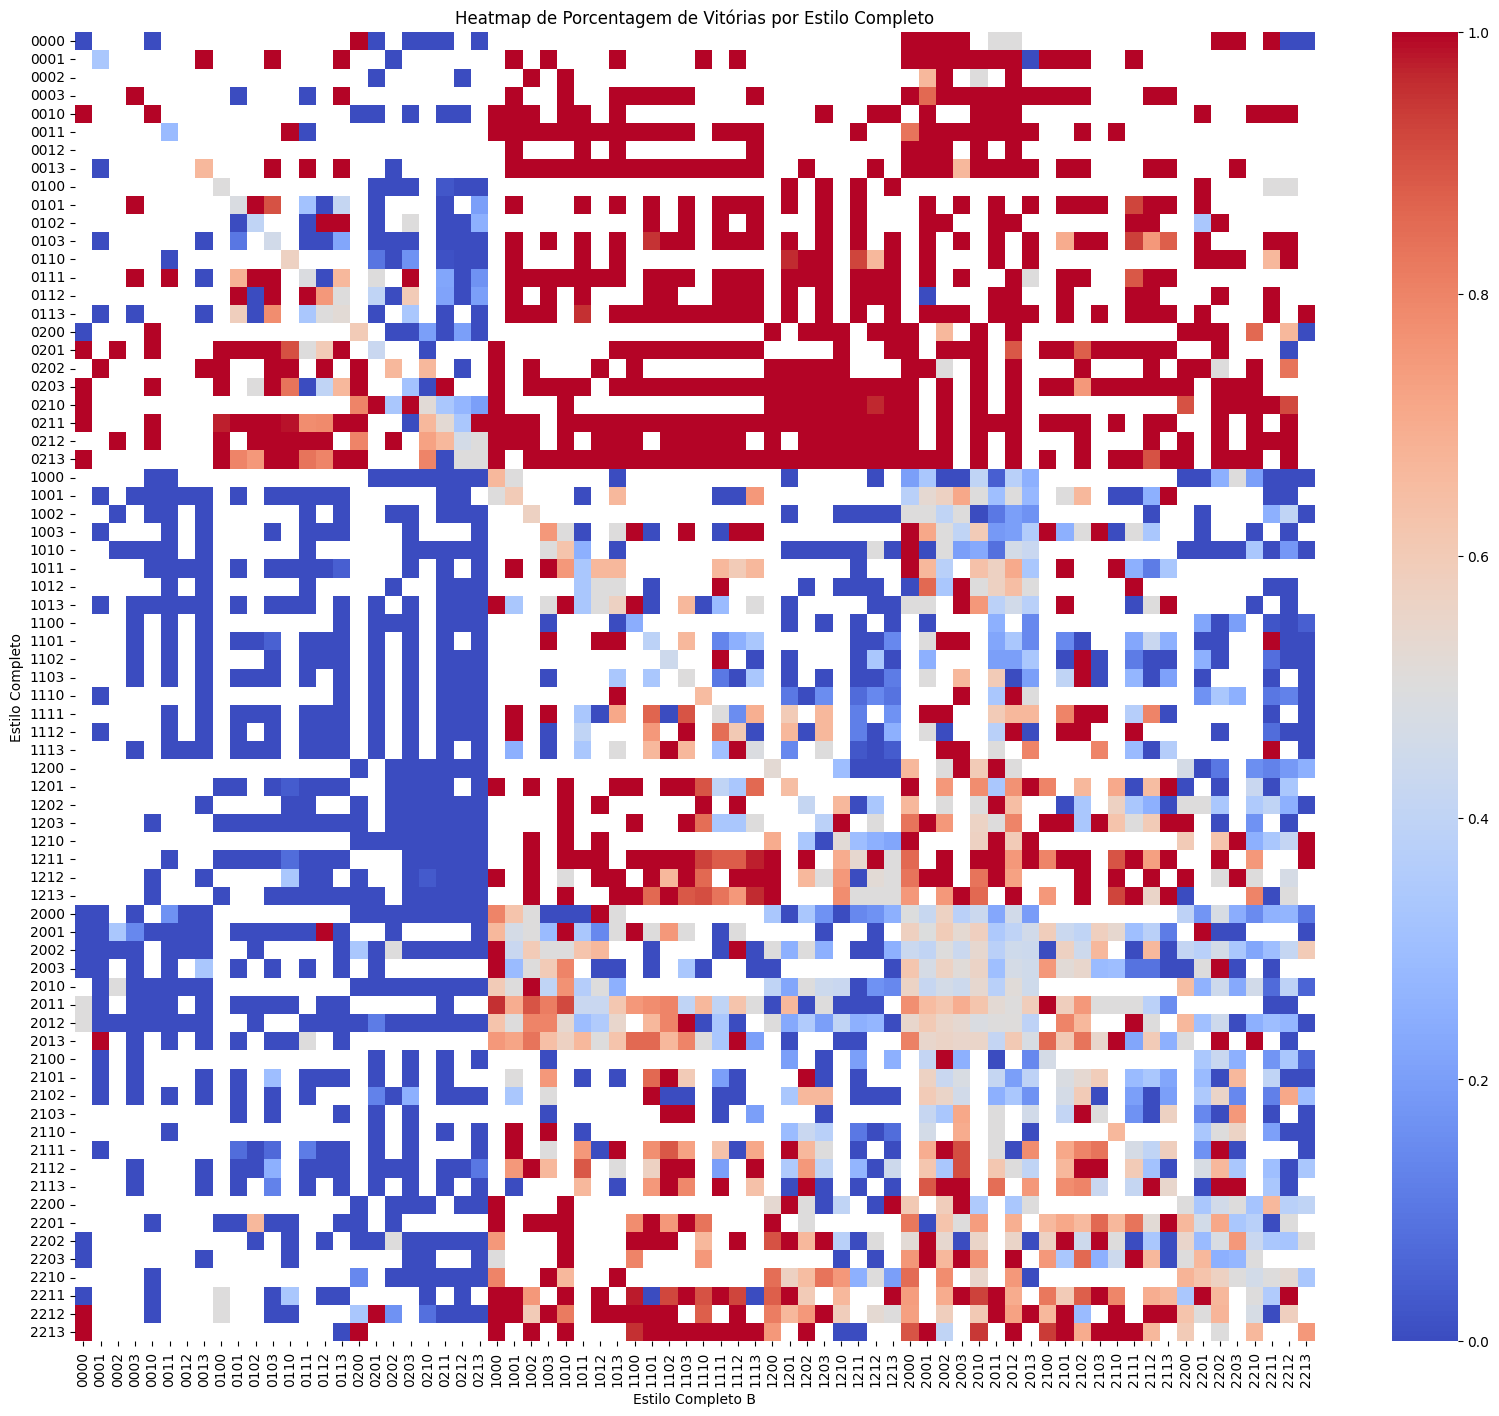

In [70]:
heatmap_data = pt.pivot(index="Estilo Completo B", columns="Estilo Completo", values="porcentagem_vitorias")

plt.figure(figsize=(20, 17))
sns.heatmap(heatmap_data, cmap="coolwarm")
plt.title("Heatmap de Porcentagem de Vitórias por Estilo Completo")
plt.xlabel("Estilo Completo B")
plt.ylabel("Estilo Completo")
plt.show()

### **Total de Vitóras por Estilo Completo**

In [64]:
df_A = resultado_agrupado.groupby('Estilo Completo').agg(
    total_partidas_A=('total_partidas', 'sum'),
    total_vitorias_A=('total_vitorias', 'sum')
).reset_index()

df_B = resultado_agrupado.groupby('Estilo Completo B').agg(
    total_partidas_B=('total_partidas', 'sum'),
    total_vitorias_B=('total_vitorias', 'sum')
).reset_index()

df_B = df_B.rename(columns={'Estilo Completo B': 'Estilo Completo'})

df_total = pd.merge(df_A, df_B, on='Estilo Completo', how='outer').fillna(0)

df_A['total_partidas'] = df_A['total_partidas_A']
df_A['total_vitorias'] = df_A['total_vitorias_A']

df_A['porcentagem_vitorias_total'] = (df_A['total_vitorias'] / df_A['total_partidas']) * 100

df_resultado_final = df_A[['Estilo Completo', 'total_partidas', 'total_vitorias', 'porcentagem_vitorias_total']]
df_resultado_final = df_resultado_final.sort_values(by='porcentagem_vitorias_total', ascending=False)
df_resultado_final[df_resultado_final['total_partidas']> 50].head(10)

,Estilo Completo,total_partidas,total_vitorias,porcentagem_vitorias_total
36,1110,1717,1666,97.029703
32,1100,761,728,95.663601
34,1102,297,279,93.939394
35,1103,873,810,92.783505
33,1101,833,759,91.116447
38,1112,555,505,90.990991
24,1000,192,165,85.937500
39,1113,1282,1101,85.881435
28,1010,180,152,84.444444
8,0100,118,97,82.203390
